In [1]:
ROOT_DIR = '/home/user/UOS-SSaS Dropbox/05. Data/00. Benchmarks/01-1. cityscapes_mini'
ENCODER = dict(type='CGNet')
DECODER = None
HEAD = dict(type='Interpolate', scale_factor=8, mode='bilinear')
DATASET =dict(type='CityscapesDataset') 
LOSS = dict(type='CrossEntropyLoss')
BATCH_SIZE = 2
PIPELINES = [
    dict(type='RandomRescale', output_range=(600, 800)),
    dict(type='RandomCrop', output_size=(400, 800)),
    dict(type='Normalization', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]),
    dict(type='ToTensor')
]


In [4]:
import sys 
sys.path.append('../')

import torch 
import torchvision as tv

from pipelines import *
from datasets import *
from models import *
from models.encoders.cgnet import *
from models.decoders import * 
from models.heads import *

from importlib import import_module

import_module('configs.cgnet')

<module 'configs.cgnet' from '../configs/cgnet.py'>

In [3]:
pipeline_list = [] 

for pipeline in PIPELINES: 
    name = pipeline.pop('type')
    pipeline_list.append(globals()[name](**pipeline))

transforms = tv.transforms.Compose(pipeline_list)


In [4]:
dataset = globals()[DATASET['type']](ROOT_DIR, transform=transforms)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [6]:
criterion = globals()[LOSS['type']]()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
encoder = globals()[ENCODER['type']]()

head_type = HEAD.pop('type')
head = globals()[head_type](**HEAD)

model = ModelWrapper(encoder=encoder, head=head)
model.to(device)

{'size': None, 'scale_factor': 8, 'mode': 'bilinear', 'align_corners': None, 'recompute_scale_factor': None, 'antialias': True}


ModelWrapper(
  (encoder): CGNet(
    (inject1): InputInjection(
      (pool): ModuleList(
        (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
      )
    )
    (inject2): InputInjection(
      (pool): ModuleList(
        (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
        (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
      )
    )
    (stage1): ModuleList(
      (0): ConvBNPReLU(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): PReLU(num_parameters=32)
      )
      (1): ConvBNPReLU(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): PReLU(num_parameters=32)
      )
      (2): ConvBNPReLU(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [9]:
import torch.optim as optim 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['segmap']

        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.530
[1,   100] loss: 1.040
[1,   150] loss: 0.948
[2,    50] loss: 0.865
[2,   100] loss: 0.877
[2,   150] loss: 0.905
[3,    50] loss: 0.881
[3,   100] loss: 0.740
[3,   150] loss: 0.802
[4,    50] loss: 0.679
[4,   100] loss: 0.738
[4,   150] loss: 0.678
[5,    50] loss: 0.768
[5,   100] loss: 0.721
[5,   150] loss: 0.682
[6,    50] loss: 0.664
[6,   100] loss: 0.703
[6,   150] loss: 0.626
[7,    50] loss: 0.653
[7,   100] loss: 0.691
[7,   150] loss: 0.632
[8,    50] loss: 0.657
[8,   100] loss: 0.604
[8,   150] loss: 0.713
[9,    50] loss: 0.599
[9,   100] loss: 0.595
[9,   150] loss: 0.635
[10,    50] loss: 0.556
[10,   100] loss: 0.601
[10,   150] loss: 0.547
[11,    50] loss: 0.596
[11,   100] loss: 0.572
[11,   150] loss: 0.540
[12,    50] loss: 0.570
[12,   100] loss: 0.540
[12,   150] loss: 0.571
[13,    50] loss: 0.561
[13,   100] loss: 0.535
[13,   150] loss: 0.471
[14,    50] loss: 0.540
[14,   100] loss: 0.526
[14,   150] loss: 0.557
[15,    50] loss: 0

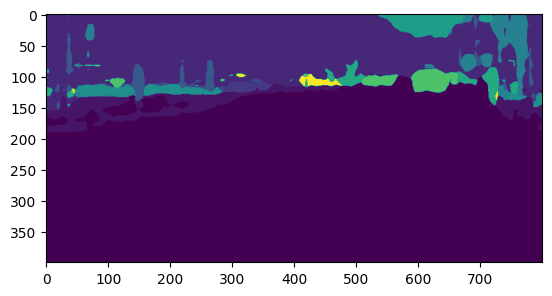

In [11]:
import matplotlib.pyplot as plt 
import numpy as np

plt.imshow(np.argmax(outputs[0, :].cpu().detach().numpy(), 0))